This store sales dataset is from Kaggle: https://www.kaggle.com/rohitsahoo/sales-forecasting. Time series analysis deals with time series based data to extract patterns for predictions and other characteristics of the data. It uses a model for forecasting future values in a small time frame based on previous observations. It is widely used for non-stationary data, such as economic data, weather data, stock prices, and retail sales forecasting.

This is a retail dataset of a global superstore for 4 years.

In this code, we will be making an in-sample and out-of-sample forecast using Prophet.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools



In [2]:
def get_data():

    ''' Read csv files
        
    Returns
    -------

    df_out:
        Dataframe containing the parameters above
    '''
    
    filenames = [i for i in glob.glob('*.{}'.format('csv'))]

    for i, f in enumerate(filenames):
        df = pd.read_csv(f)

    return df


Save to parquet for fewer storage.

In [3]:
df = get_data()

df.to_parquet('sales.parquet')

In [4]:
df = pd.read_parquet('sales.parquet')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
# Check for null values

df.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

There are missing values in the Postal Code, we can drop them.

In [7]:
# Remove missing values
df = df.dropna()

In [8]:
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

No duplicates.

In [9]:
df.duplicated().sum()

0

In [10]:
df[['Order Date','Ship Date']] = df[['Order Date','Ship Date']].apply(pd.to_datetime)
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df['Order Year Month'] = df['Order Date'].apply(lambda x: x.strftime('%Y-%m'))
df['Ship Year Month'] = df['Ship Date'].apply(lambda x: x.strftime('%Y-%m'))

In [11]:
df = df.sort_values(by='Order Date')

In [12]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Order Year Month,Ship Year Month
540,541,CA-2015-140795,2015-01-02,2015-03-02,First Class,BD-11500,Bradley Drucker,Consumer,United States,Green Bay,Wisconsin,54302.0,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900,2015-01,2015-03
7950,7951,CA-2015-131009,2015-01-03,2015-05-03,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,OFF-ST-10001469,Office Supplies,Storage,Fellowes Bankers Box Recycled Super Stor/Drawer,129.552,2015-01,2015-05
7948,7949,CA-2015-131009,2015-01-03,2015-05-03,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,FUR-CH-10001270,Furniture,Chairs,Harbour Creations Steel Folding Chair,362.250,2015-01,2015-05
7947,7948,CA-2015-131009,2015-01-03,2015-05-03,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,OFF-FA-10004395,Office Supplies,Fasteners,Plymouth Boxed Rubber Bands by Plymouth,18.840,2015-01,2015-05
8309,8310,CA-2015-168312,2015-01-03,2015-07-03,Standard Class,GW-14605,Giulietta Weimer,Consumer,United States,Houston,Texas,77036.0,Central,OFF-ST-10003692,Office Supplies,Storage,Recycled Steel Personal File for Hanging File ...,137.352,2015-01,2015-07


### What is the most preferred shipping mode?

In [13]:
df['Ship Mode'].nunique()

4

Text(0.5, 0, 'Number of Sales')

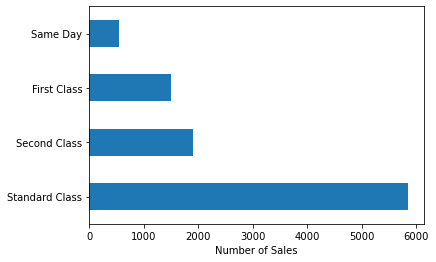

In [14]:
shipping_mode = df['Ship Mode'].value_counts()
shipping_mode = shipping_mode.sort_values(ascending = False)

shipping_mode.plot.barh()
plt.xlabel('Number of Sales')

* Standard Class is the most preferred shipping mode

### Which segment has the most sales?

In [15]:
df['Segment'].nunique()

3

Text(0.5, 0, 'Number of Sales')

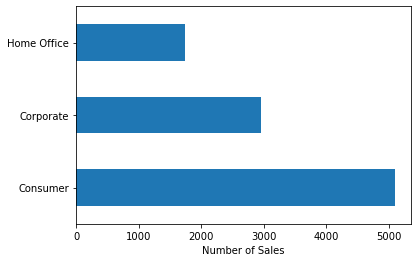

In [16]:
segment = df['Segment'].value_counts()
segment = segment.sort_values(ascending = False)

segment.plot.barh()
plt.xlabel('Number of Sales')

* Ordinary consumers buy from the store the most.

### Which state has the most sales?

In [17]:
df['State'].nunique()

48

There are 48 different states in the dataset. Let's look at the 20 states that generate most profit.

Text(0.5, 0, 'Number of Sales')

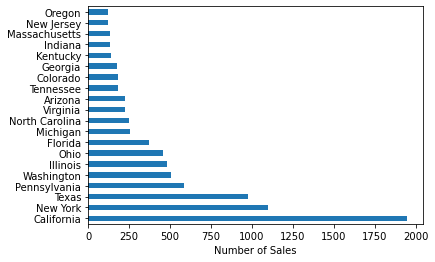

In [18]:
state_count = df['State'].value_counts()
state_count = state_count.sort_values(ascending = False)

state_count.head(20).plot.barh()
plt.xlabel('Number of Sales')

* The state of California generated most sales.

### Which city has the most sales?

In [19]:
df['City'].nunique()

529

There are 529 different states in the dataset. Let's just look at the 20 cities that generate most profit.

Text(0.5, 0, 'Number of Sales')

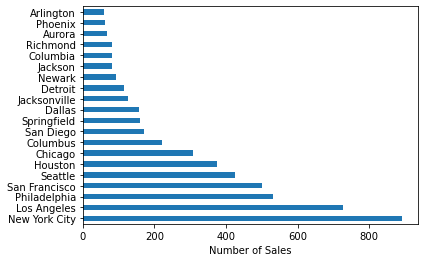

In [20]:
city_count = df['City'].value_counts()
city_count = city_count.sort_values(ascending = False)

city_count.head(20).plot.barh()
plt.xlabel('Number of Sales')

* The city of New York generated most sales.

### Which category has the most sales?

In [21]:
df['Category'].nunique()

3

Text(0.5, 0, 'Number of Sales')

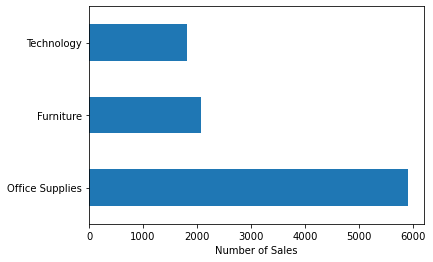

In [22]:
category = df['Category'].value_counts()
category = category.sort_values(ascending = False)

category.plot.barh()
plt.xlabel('Number of Sales')

* Office supplies is the most selling category.

### Which sub-category has the most sales?

In [23]:
df['Sub-Category'].nunique()

17

Text(0.5, 0, 'Number of Sales')

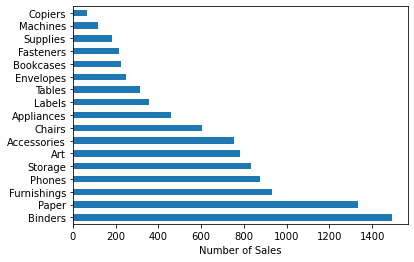

In [24]:
sub_category = df['Sub-Category'].value_counts()
sub_category = sub_category.sort_values(ascending = False)

sub_category.plot.barh()
plt.xlabel('Number of Sales')

* As office supplies is the most-selling category, the top 2 most-selling sub-categories (paper and binders) is under this category.

### Which specific products has the most sales?

In [25]:
df['Product Name'].nunique()

1848

There are 1848 products in the dataset. Let's just look at the 20 products that generate most profit.

Text(0.5, 0, 'Number of Sales')

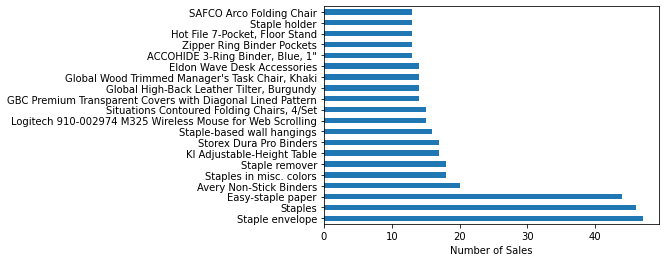

In [26]:
product = df['Product Name'].value_counts()
product = product.sort_values(ascending = False)

product.head(20).plot.barh()
plt.xlabel('Number of Sales')

* The products that were top-bought were easy-staple papers, staples, and staple envelope.

### Which months have the most sales?

Text(0.5, 0, 'Number of Sales')

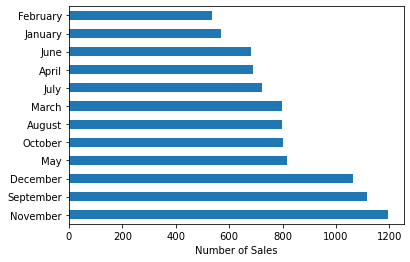

In [27]:
month = df['Order Date'].dt.month_name().value_counts()
month = month.sort_values(ascending = False)

month.plot.barh()
plt.xlabel('Number of Sales')

* The months with top sales might be affected by holidays in USA, like Christmas and Thanksgiving.

## Forecast Store Sales With Prophet

In [28]:
df_prophet = df[["Order Date","Sales"]]

The start year of this dataset is 2015.

In [29]:
df_prophet.head()

,Order Date,Sales
540,2015-01-02,468.900
7950,2015-01-03,129.552
7948,2015-01-03,362.250
7947,2015-01-03,18.840
8309,2015-01-03,137.352


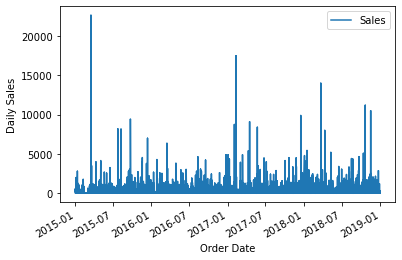

In [30]:
# Plot the time series
df_prophet.plot('Order Date')
plt.xlabel('Order Date')
plt.ylabel('Daily Sales')
plt.show()

In [31]:
df_prophet = df_prophet.rename(columns = {'Order Date': 'ds','Sales': 'y'})

# Let's look at the store sales of the latest dates
df_prophet.tail()

,ds,y
645,2018-12-30,209.300
906,2018-12-30,323.136
1296,2018-12-30,13.904
1297,2018-12-30,20.720
907,2018-12-30,90.930


The end year of the dataset is 2018.

In [32]:
# The function below returns a dataframe of desired start date to desired end date
def gen_days(start_year, start_month, start_day, end_year, end_month, end_day):
    start_date=pd.datetime(start_year, start_month, start_day)
    end_date=pd.datetime(end_year, end_month, end_day)
    d=start_date
    dates=[ start_date ]
    while d < end_date:
        d += timedelta(days=1)
        dates.append( d )
    return pd.DataFrame(dates)

### 1) Make an In-Sample Forecast

Let's make a prediction on store sales of 2018 based on the store sales from 2015 to 2017.

In [33]:
# Define the model
prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)

# Training dataset
index_2018 = df_prophet.index[df_prophet['ds'].dt.year.isin([2018])]
train = df_prophet.copy()
train = train.drop(index_2018)

In [34]:
train.tail()

,ds,y
5738,2017-12-31,38.376
2821,2017-12-31,302.376
6341,2017-12-31,156.512
4613,2017-12-31,23.480
4612,2017-12-31,47.616


In [35]:
# Fit the model
prophet_model.fit(train)

# Predict the store sales
in_sample_future = gen_days(2018, 1, 1, 2018, 12, 30)
in_sample_future.columns = ['ds']

in_sample_forecast = prophet_model.predict(in_sample_future)

/var/folders/20/h3bwm1qj7cz6s_fwcr2jvvf40000gn/T/ipykernel_37473/917928291.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date=pd.datetime(start_year, start_month, start_day)
/var/folders/20/h3bwm1qj7cz6s_fwcr2jvvf40000gn/T/ipykernel_37473/917928291.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date=pd.datetime(end_year, end_month, end_day)


Initial log joint probability = -4.73496
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       20021.1   0.000670855       349.488           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       20021.3   2.73197e-05       225.401      0.3763      0.9171      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       20021.4   6.20807e-05       534.411   2.857e-07       0.001      351  LS failed, Hessian reset 
     276       20021.5   6.80149e-06        192.19   3.221e-08       0.001      441  LS failed, Hessian reset 
     299       20021.5   8.83846e-07       65.1938      0.6848      0.6848      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       20021.5   9.84348e-07       75.5447      0.6781      0.6781      481   
Optimization terminat

In [36]:
in_sample_forecast.shape

(364, 22)

There are multiple sales within a day, so what we can get is the average sales per day in year 2018 in our dataset.

In [37]:
y = df_prophet[df_prophet['ds'].dt.year.isin([2018])]
y_mean = y.groupby('ds', as_index=False)['y'].mean()

In [38]:
y_mean.shape

(322, 2)

There's a discrepency between the shapes of predicted sales and true sales. I'll just disregard the predictions in the dates outside the dataset. 

In [39]:
matching_dates = in_sample_forecast['ds'].isin(y_mean['ds'])
keep_forecast = in_sample_forecast[matching_dates]

In [40]:
y_true = y_mean['y'].values
y_pred = keep_forecast['yhat'].values

mean absolute error: 159.643


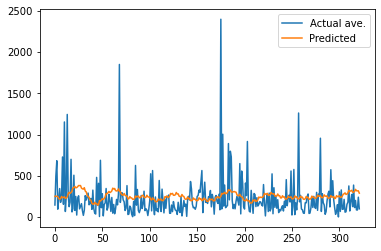

In [41]:
# Get the mean absolute error
mae = mean_absolute_error(y_true, y_pred)
print('mean absolute error: %.3f' % mae)

# Plot expected vs actual
pyplot.plot(y_true, label='Actual ave.')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

The prediction got most of the average sales except for the peaks.

### 2) Make an Out-of-Sample Forecast

Let's make a prediction on the sales of the next 4 months (~120 days) from the last date of the dataset.

In [42]:
# Define the model
prophet_model2 = Prophet(interval_width=0.95, daily_seasonality=True)

# Fit the model
prophet_model2.fit(df_prophet)

# Predict the store sales
out_sample_future = prophet_model2.make_future_dataframe(periods=120,freq='D')
out_sample_forecast = prophet_model2.predict(out_sample_future)

Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30254.2   0.000385464       299.561      0.4204           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30254.7   0.000118449       215.679           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30254.8    6.8057e-05       106.496      0.7807      0.7807      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       30254.8   3.69651e-06       74.0788           1           1      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


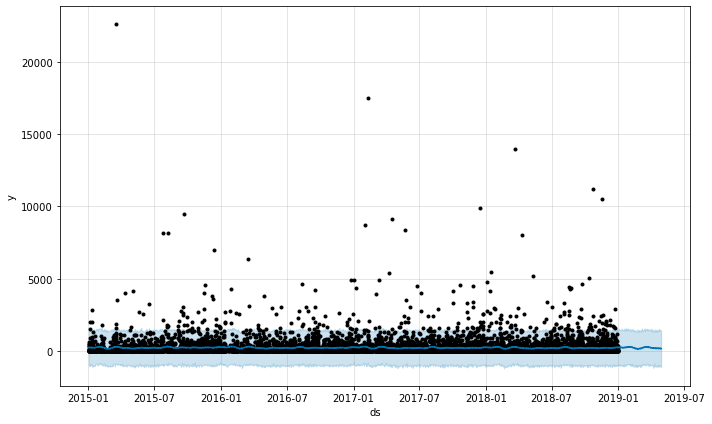

In [43]:
prophet_model2.plot(out_sample_forecast)
pyplot.show()

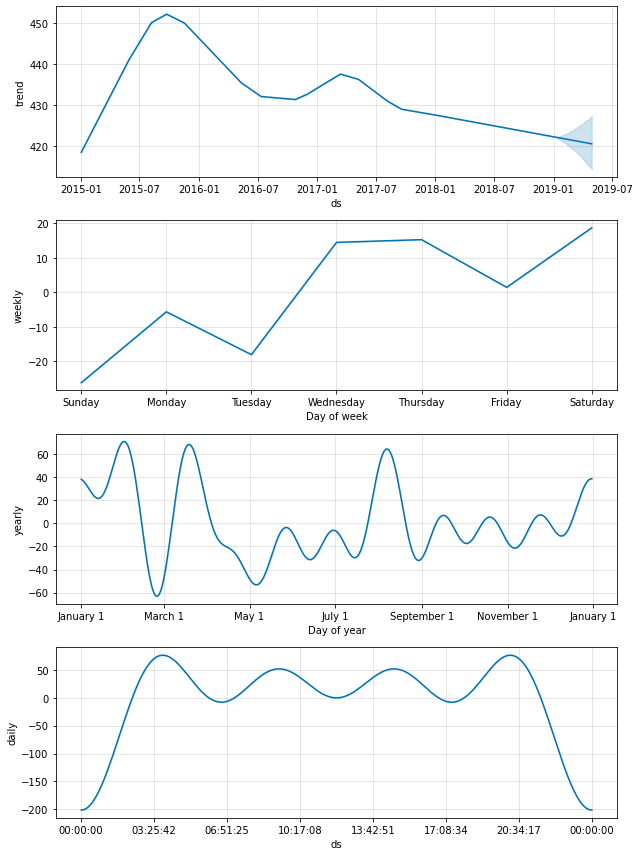

In [44]:
plot_2 = prophet_model2.plot_components(out_sample_forecast)

### Cross-Validation

In [45]:
df_cv = cross_validation(prophet_model2, initial='730 days', horizon = '365 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-06-30 12:00:00 and 2017-12-30 00:00:00
  0%|          | 0/2 [00:00<?, ?it/s]

Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         15347   5.22424e-05       111.823      0.6996      0.6996      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       15347.1   1.80522e-05       205.741   1.637e-07       0.001      215  LS failed, Hessian reset 
     199       15347.1   4.54357e-06       66.5751           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       15347.1    1.1023e-06       51.8363      0.3435           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19996.3   5.32207e-05       114.089      0.2723      0.5922      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19996.6   8.20772e-05       89.4341           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       19996.8   1.58547e-05       355.139   7.236e-08       0.001      376  LS failed, Hessian reset 
     299       19996.8   4.92903e-05       259.524      0.5705      0.5705      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       19996.8   4.62945e-07       75.3717      0.1234      0.3745      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


In [46]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-07-01,208.673511,-1063.099986,1622.745713,34.580,2017-06-30 12:00:00
1,2017-07-01,208.673511,-989.298300,1473.067437,25.920,2017-06-30 12:00:00
2,2017-07-01,208.673511,-1087.726436,1556.275372,23.076,2017-06-30 12:00:00
3,2017-07-02,185.815178,-1198.524340,1494.537296,623.960,2017-06-30 12:00:00
4,2017-07-02,185.815178,-1185.987988,1511.818619,100.000,2017-06-30 12:00:00


In [47]:
cutoffs = pd.to_datetime(['2017-06-30', '2017-12-30'])
df_cv2 = cross_validation(prophet_model2, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/2 [00:00<?, ?it/s]

Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         15347   5.22424e-05       111.823      0.6996      0.6996      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       15347.1   1.80522e-05       205.741   1.637e-07       0.001      215  LS failed, Hessian reset 
     199       15347.1   4.54357e-06       66.5751           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       15347.1    1.1023e-06       51.8363      0.3435           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19996.3   5.32207e-05       114.089      0.2723      0.5922      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19996.6   8.20772e-05       89.4341           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       19996.8   1.58547e-05       355.139   7.236e-08       0.001      376  LS failed, Hessian reset 
     299       19996.8   4.92903e-05       259.524      0.5705      0.5705      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       19996.8   4.62945e-07       75.3717      0.1234      0.3745      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


In [48]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,42 days 12:00:00,311558.453988,558.174215,324.920203,14.494632,4.596399,0.970588
1,43 days 00:00:00,291807.488817,540.192085,322.562224,14.689304,4.856360,0.970724
2,43 days 12:00:00,264175.956454,513.980502,317.355314,14.734246,4.856360,0.972086
3,44 days 00:00:00,250904.722966,500.903906,315.670573,14.223213,4.648478,0.973856
4,44 days 12:00:00,249423.190117,499.422857,314.566280,14.263692,4.765350,0.973856


/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


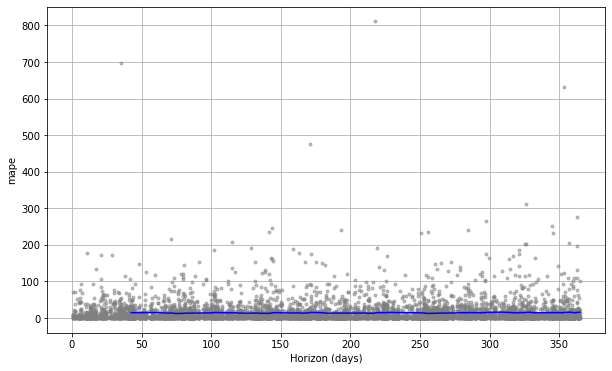

In [49]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Hyperparameter Tuning

In [50]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Finding the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0d8490>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       30252.8   1.98775e-06        5032.6   3.926e-10       0.001      166  LS failed, Hessian reset 
      99       30252.8   5.01001e-07       4880.44      0.2202           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       30252.8   6.87223e-09       4815.39     0.09939     0.09939      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19994.5   2.72366e-08       4922.37      0.5431      0.5431      130   
    Iter      log prob        ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbe8c3b340>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       30253.6   2.33701e-05       5088.29   4.606e-09       0.001      139  LS failed, Hessian reset 
      99       30253.7   4.90215e-07       5068.87      0.1748           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       30253.7   1.16733e-06       5029.03    2.31e-10       0.001      225  LS failed, Hessian reset 
     142       30253.7   3.20443e-07       5009.86   6.352e-11       0.001      304  LS failed, Hessian reset 
     151       30253.7    3.1691e-09       5096.01       0.167       0.167      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbf86f7760>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       30253.6   2.53743e-05       4998.38   5.036e-09       0.001      160  LS failed, Hessian reset 
      99       30253.7   1.08326e-06       5072.13           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       30253.7   9.79096e-09       4973.29      0.1435      0.1435      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       15345.9   7.39019e-09       4837.22      0.1628      0.1628      129   
Optimization terminated normally

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0c1340>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30253.4   6.65599e-08       4591.78      0.3862      0.3862      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       30253.4   1.23799e-06       5072.24   2.455e-10       0.001      184  LS failed, Hessian reset 
     121       30253.4    4.6071e-09        4879.3     0.05425           1      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       19995.8   4.82161e-09       4962.57      0.2511      0.2511      121   
Optimization terminated normally

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0ea2e0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30253.7   2.00519e-05       533.019       0.614       0.614      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       30253.7   4.19727e-07       507.712           1           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19995.7   4.09319e-05       482.858           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         15346    4.9307e-07       358.673

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdc0d2f42e0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       30253.6   2.88384e-05        543.32   2.761e-08       0.001      165  LS failed, Hessian reset 
      99       30253.8   6.18844e-05       510.523           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       30254.4   2.57525e-07       468.578      0.3264      0.3264      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15346.1   1.72181e-05       265.291           1           1      124   
    Iter      log prob        |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbf84cac40>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30253.7   0.000293528       721.273      0.6972           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       30254.3   8.41049e-05       904.478   1.599e-07       0.001      222  LS failed, Hessian reset 
     165       30254.4   2.19495e-07       384.501      0.2747      0.5404      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19995.7   1.38096e-05       457.606           1           1      122   
    Iter      log prob        |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0c62e0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30253.9   6.37038e-05        444.17      0.2391           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       30254.3   2.88912e-05        675.16   4.181e-08       0.001      204  LS failed, Hessian reset 
     152       30254.3   2.45183e-05       509.581   4.729e-08       0.001      270  LS failed, Hessian reset 
     169       30254.3   2.41439e-07       388.815      0.3687           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      9

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbf84ca2e0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30255.2   4.27888e-05       97.6838           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       30255.4    1.3093e-05        235.26    7.59e-08       0.001      213  LS failed, Hessian reset 
     199       30255.5   6.92356e-05       151.162           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30255.7   0.000216126       203.682           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30255.8   8.25026e-06       55.0049      0.3429      0.3429      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       30255.8   1.07642e-05    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0c6dc0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         30255   3.74071e-05       130.948      0.9963      0.9963      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30255.5   1.49141e-05       90.1966    0.007886           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       30255.6   1.20176e-05       133.895   1.474e-07       0.001      307  LS failed, Hessian reset 
     272       30255.6   5.41648e-06       39.6315      0.2634           1      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.73888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68041
    Iter      log prob        |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdc0d915e20>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         30255    0.00237007       740.074           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30255.5   8.82612e-05       110.268           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30255.8   8.62083e-05        174.87       0.511           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30255.9   8.73636e-05       41.1287      0.7843      0.7843      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       30255.9    8.3515e-06       34.0988           1           1      520   
Optimization terminated normally: 
  Convergence detected: relat

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbe85e69a0>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30255.1      0.003042       806.697           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30255.6   9.00906e-05        107.49           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30255.8   0.000249973       208.201      0.2592      0.2592      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       30255.8   2.97671e-06       58.8328   2.992e-08       0.001      400  LS failed, Hessian reset 
     337       30255.8   4.11212e-06       87.3651    4.04e-08       0.001      488  LS failed, Hessian reset 
     399       30255.9   8.50617e-05       91.8589      0.9707      0.9707      562   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbdb0de970>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30256.3   0.000129739       249.123      0.2248           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30257.5   0.000362147       384.081      0.3588      0.3588      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30258.9   0.000361874       219.408           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       30259.1   8.80853e-06       18.6056           1           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.68041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Init

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbf8ff1670>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30256.4   6.38358e-05       105.058           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30258.3    0.00150667       172.319           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30258.7    4.6908e-05       124.862      0.2003           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30259.1   0.000121003       108.762       1.009      0.1009      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30259.3   8.81829e-05        74.842      0.6963      0.6963      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbe8bf6730>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30256.2    0.00056839       384.056           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30258.3        0.0011       247.797           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30258.8   0.000117693         155.6      0.5075           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         30259    7.4636e-05       89.7519           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30259.3    0.00041131       99.8188           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdbe8c3ea00>


Initial log joint probability = -5.88213
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30256.1   0.000163314        155.61           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30258.1    0.00476417       104.961           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30258.9   0.000690487       153.184           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30259.1   0.000114692       53.0068           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30259.4   0.000701045       78.0844           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [51]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  613.014849
1                     0.001                     0.10  613.596961
2                     0.001                     1.00  612.699739
3                     0.001                    10.00  612.673506
4                     0.010                     0.01  612.679377
5                     0.010                     0.10  612.759312
6                     0.010                     1.00  612.713745
7                     0.010                    10.00  612.714056
8                     0.100                     0.01  613.798716
9                     0.100                     0.10  613.871721
10                    0.100                     1.00  613.798850
11                    0.100                    10.00  613.799337
12                    0.500                     0.01  613.742848
13                    0.500                     0.10  613.575000
14                    0.5

Here are the best parameter values to use for this model:

In [52]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}
